# MIDAS Examples

If you're reading this you probably already know that MIDAS stands for Mixed Data Sampling, and it is a technique for creating time-series forecast models that allows you to mix series of different frequencies (ie, you can use monthly data as predictors for a quarterly series, or daily data as predictors for a monthly series, etc.).  The general approach has been described in a series of papers by Ghysels, Santa-Clara, Valkanov and others.

This notebook attempts to recreate some of the examples from the paper [_Forecasting with Mixed Frequencies_](https://research.stlouisfed.org/publications/review/2010/11/01/forecasting-with-mixed-frequencies/) by Michelle T. Armesto, Kristie M. Engemann, and Michael T. Owyang.

In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd

from midas.mix import mix_freq
from midas.adl import estimate, forecast, midas_adl, rmse

# MIDAS ADL

This package currently implements the MIDAS ADL (autoregressive distributed lag) method.  We'll start with an example using quarterly GDP and monthly payroll data.  We'll then show the basic steps in setting up and fitting this type of model, although in practice you'll probably used the top-level __midas_adl__ function to do forecasts.

TODO: MIDAS equation and discussion


# Example 1: GDP vs Non-Farm Payroll

In [2]:
gdp = pd.read_csv('../tests/data/gdp.csv', parse_dates=['DATE'], index_col='DATE')
pay = pd.read_csv('../tests/data/pay.csv', parse_dates=['DATE'], index_col='DATE')
gdp.tail()

,GDP
DATE,
2010-04-01,14467.8
2010-07-01,14605.5
2010-10-01,14755.0
2011-01-01,14867.8
2011-04-01,14996.8


In [3]:
pay.tail()

,PAY
DATE,
2011-03-01,130757
2011-04-01,130974
2011-05-01,131027
2011-06-01,131073
2011-07-01,131190


## Figure 1

This is a variation of Figure 1 from the paper comparing year-over-year growth of GDP and employment.

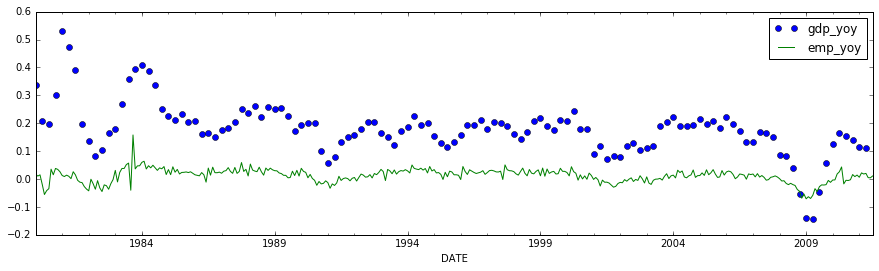

In [4]:
gdp_yoy = ((1. + (np.log(gdp.GDP) - np.log(gdp.GDP.shift(3)))) ** 4) - 1.
emp_yoy = ((1. + (np.log(pay.PAY) - np.log(pay.PAY.shift(1)))) ** 12) - 1.
df = pd.concat([gdp_yoy, emp_yoy], axis=1)
df.columns = ['gdp_yoy', 'emp_yoy']
df[['gdp_yoy','emp_yoy']].loc['1980-1-1':].plot(figsize=(15,4), style=['o','-'])

## Mixing Frequencies

The first step is to do the actual frequency mixing.  In this case we're mixing monthly data (employment) with quarterly data (GDP).  This may sometimes be useful to do directly, but again you'll probably used __midas_adl__ to do forecasting.

In [5]:
gdp['gdp_growth'] = (np.log(gdp.GDP) - np.log(gdp.GDP.shift(1))) * 100.
pay['emp_growth'] = (np.log(pay.PAY) - np.log(pay.PAY.shift(1))) * 100.

y, yl, x, yf, ylf, xf = mix_freq(gdp.gdp_growth, pay.emp_growth, "3m", 1, 3,
                                 start_date=datetime.datetime(1985,1,1),
                                 end_date=datetime.datetime(2009,1,1))
x.head()

,0,1,2
DATE,,,
1985-01-01,0.299577,0.326786,0.253969
1985-04-01,0.276450,0.132259,0.364356
1985-07-01,0.201196,0.357993,0.128611
1985-10-01,0.193784,0.148925,0.282024
1986-01-01,0.190590,0.208331,0.197498


The arguments here are as follows:
- First, the dependent (low frequency) and independent (high-frequency) data are given as Pandas series, and they are assumed to be indexed by date.
- xlag  The number of lags for the high-frequency variable
- ylag  The number of lags for the low-frequency variable (the autoregressive part)
- horizon: How much the high-frequency data is lagged before frequency mixing
- start_date, end_date: The start and end date over which the model is fitted.  If these are outside the range of the low-frequency data, they will be adjusted


The _horizon_ argument is a little tricky (the argument name was retained from the MatLab version).  This is used both the align the data and to do _nowcasting_ (more on that later).  For example, if it's September 2017 then the latest GDP data from FRED will be for Q2 and this will be dated 2017-04-01.  The latest monthly data from non-farm payroll will be for August, which will be dated 2017-08-01.  If we aligned just on dates, the payroll data for April (04-01), March (03-01), and February(02-01) would be aligned with Q2 (since xlag = "3m"), but what we want is June, May, and April, so here the horizon argument is 3 indicating that the high-frequency data should be lagged three months before being mixed with the quarterly data.

### Fitting the Model

Because of the form of the MIDAS model, fitting the model requires using non-linear least squares.  For now, if you call the __estimate__ function directly, you'll get back a results of type scipy.optimize.optimize.OptimizeResult


In [6]:
res = estimate(y, yl, x, poly='beta')
res.x

array([ 0.67190062,  1.85207778,  1.03432056,  4.14112643,  0.28559855])

You can also call __forecast__ directly.  This will use the optimization results returned from __eatimate__ to produce a forecast for every date in the index of the forecast inputs (here xf and ylf):

In [7]:
fc = forecast(xf, ylf, res, poly='beta')
forecast_df = fc.join(yf)
forecast_df['gap'] = forecast_df.yfh - forecast_df.gdp_growth
forecast_df

,yfh,gdp_growth,gap
DATE,,,
2009-04-01,-0.767579,-0.285428,-0.482150
2009-07-01,-0.388788,0.478136,-0.866924
2009-10-01,0.303540,1.191821,-0.888281
2010-01-01,0.690742,1.343211,-0.652468
2010-04-01,0.963705,1.321260,-0.357556
2010-07-01,1.411772,0.947268,0.464504
2010-10-01,0.816413,1.018384,-0.201971
2011-01-01,1.127789,0.761579,0.366210
2011-04-01,1.019080,0.863904,0.155176


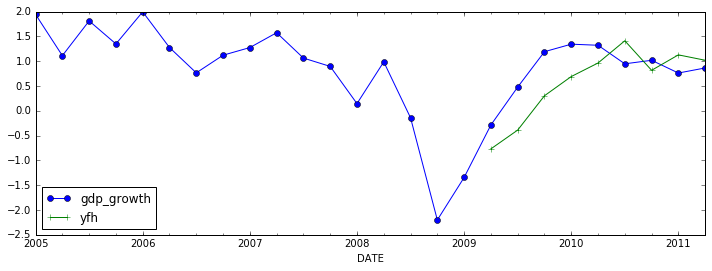

In [8]:
gdp.join(fc)[['gdp_growth','yfh']].loc['2005-01-01':].plot(style=['-o','-+'], figsize=(12, 4))

### Comparison against univariate ARIMA model

In [9]:
import statsmodels.tsa.api as sm

m = sm.AR(gdp['1975-01-01':'2011-01-01'].gdp_growth,)
r = m.fit(maxlag=1)
r.params
fc_ar = r.predict(start='2005-01-01')
fc_ar.name = 'xx'

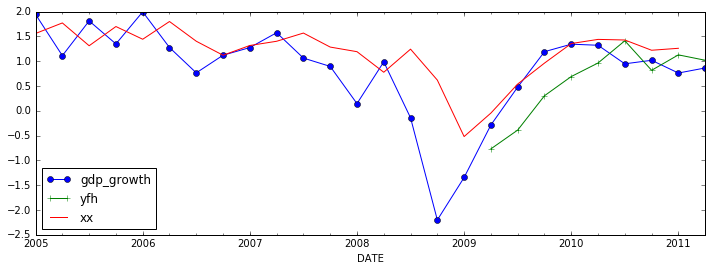

In [10]:
df_p = gdp.join(fc)[['gdp_growth','yfh']]
df_p.join(fc_ar)[['gdp_growth','yfh','xx']].loc['2005-01-01':].plot(style=['-o','-+'], figsize=(12, 4))

## The midas_adl function

The __midas\_adl__ function wraps up frequency-mixing, fitting, and forecasting into one process.  The default mode of forecasting is _fixed_, which means that the data between start_date and end_date will be used to fit the model, and then any data in the input beyond end_date will be used for forecasting.  For example, here we're fitting from the beginning of 1985 to the end of 2008, but the gdp data extends to Q1 of 2011 so we get nine forecast points.  Three monthly lags of the high-frequency data are specified along with one quarterly lag of GDP.


In [11]:
rmse_fc, fc = midas_adl(gdp.gdp_growth, pay.emp_growth,
                            start_date=datetime.datetime(1985,1,1),
                            end_date=datetime.datetime(2009,1,1),
                            xlag="3m",
                            ylag=1,
                            horizon=3)
rmse_fc

0.55190316650507854

You can also change the polynomial used to weight the MIDAS coefficients. The default is 'beta', but you can also specify exponential Almom weighting ('expalmon') or beta with non-zero last term ('betann')

In [13]:
rmse_fc, fc = midas_adl(gdp.gdp_growth, pay.emp_growth,
                            start_date=datetime.datetime(1985,1,1),
                            end_date=datetime.datetime(2009,1,1),
                            xlag="3m",
                            ylag=1,
                            horizon=3,
                            poly='expalmon')
rmse_fc

0.55428836726300179

### Rolling and Recursive Forecasting

As mentioned above the default forecasting method is fixed where the model is fit once and then all data after end_date is used for forecasting.  Two other methods are supported _rolling window_ and _recursive_.  The _rolling window_ method is just what it sounds like.  The start_date and end_date are used for the initial window, and then each new forecast moves that window forward by one period so that you're always doing one step ahead forecasts.  Of course, to do anything useful this also assumes that the date range of the dependent data extends beyond end_date accounting for the lags implied by _horizon_.  Generally, you'll get lower RMSE values here since the forecasts are always one step ahead.

In [14]:
results = {h: midas_adl(gdp.gdp_growth, pay.emp_growth,
                            start_date=datetime.datetime(1985,10,1),
                            end_date=datetime.datetime(2009,1,1),
                            xlag="3m",
                            ylag=1,
                            horizon=3,
                            forecast_horizon=h,
                            poly='beta',
                            method='rolling') for h in (1, 2, 5)}
results[1][0]

0.47833843205027515

The _recursive_ method is similar except that the start date does not change, so the range over which the fitting happens increases for each new forecast.

In [15]:
results = {h: midas_adl(gdp.gdp_growth, pay.emp_growth,
                            start_date=datetime.datetime(1985,10,1),
                            end_date=datetime.datetime(2009,1,1),
                            xlag="3m",
                            ylag=1,
                            horizon=3,
                            forecast_horizon=h,
                            poly='beta',
                            method='recursive') for h in (1, 2, 5)}
results[1][0]

0.47889011061031994

## Nowcasting

Per the manual for the MatLab Matlab Toolbox Version 1.0, you can do _nowcasting_ (or MIDAS with leads) basically by adjusting the _horizon_ parameter.  For example, below we change the _horizon_ paremter to 1, we're now forecasting with a one month horizon rather than a one quarter horizon:

In [33]:
rmse_fc, fc = midas_adl(gdp.gdp_growth, pay.emp_growth,
                            start_date=datetime.datetime(1985,1,1),
                            end_date=datetime.datetime(2009,1,1),
                            xlag="3m",
                            ylag=1,
                            horizon=1)
rmse_fc

0.4988413919233991

Not surprisingly the RMSE drops considerably.

## CPI vs. Federal Funds Rate

__UNDER CONSTRUCTION: Note that these models take considerably longer to fit__

In [16]:
cpi = pd.read_csv('CPIAUCSL.csv', parse_dates=['DATE'], index_col='DATE')
ffr = pd.read_csv('DFF_2_Vintages_Starting_2009_09_28.txt', sep='\t', parse_dates=['observation_date'],
                  index_col='observation_date')

In [17]:
cpi.head()

,CPIAUCSL
DATE,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [18]:
ffr.head(10)

,DFF_20090928
observation_date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88
1954-07-06,0.25
1954-07-07,1.00
1954-07-08,1.25
1954-07-09,1.25


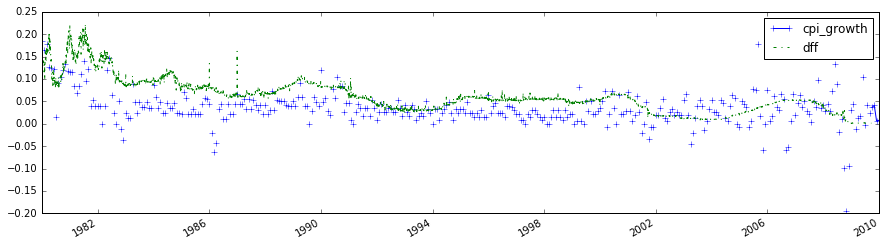

In [19]:
cpi_yoy = ((1. + (np.log(cpi.CPIAUCSL) - np.log(cpi.CPIAUCSL.shift(1)))) ** 12) - 1.
cpi_yoy.head()
df = pd.concat([cpi_yoy, ffr.DFF_20090928 / 100.], axis=1)
df.columns = ['cpi_growth', 'dff']
df.loc['1980-1-1':'2010-1-1'].plot(figsize=(15,4), style=['-+','-.'])

In [20]:
cpi_growth = (np.log(cpi.CPIAUCSL) - np.log(cpi.CPIAUCSL.shift(1))) * 100.

y, yl, x, yf, ylf, xf = mix_freq(cpi_growth, ffr.DFF_20090928, "1m", 1, 1,
                                 start_date=datetime.datetime(1975,10,1),
                                 end_date=datetime.datetime(1991,1,1))

In [21]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
DATE,,,,,,,,,,,,,,,,,,,,,
1975-10-01,6.22,6.42,6.42,6.42,6.42,6.38,6.54,6.26,6.28,6.21,...,5.98,6.09,6.19,6.20,6.20,6.20,6.19,5.47,6.29,6.13
1975-11-01,5.65,5.64,5.67,5.63,5.67,5.64,5.64,5.64,5.66,5.77,...,5.79,5.79,5.87,5.73,5.80,6.03,6.18,6.18,6.18,6.30
1975-12-01,5.29,5.29,5.29,5.34,5.34,5.26,5.31,5.26,5.26,5.26,...,5.18,5.22,5.22,5.22,5.31,2.99,4.94,5.65,5.65,5.65
1976-01-01,5.37,5.30,5.10,5.15,5.15,5.15,5.02,5.02,5.18,5.24,...,5.25,5.09,5.23,5.32,5.31,5.31,5.31,5.24,4.96,5.29
1976-02-01,4.84,4.84,4.82,5.12,4.79,4.77,4.72,4.72,4.72,4.77,...,4.73,4.73,4.73,4.84,4.26,5.05,5.29,5.28,5.28,5.28


In [22]:
res = estimate(y, yl, x)

In [23]:
fc = forecast(xf, ylf, res)
fc.join(yf).head()

,yfh,CPIAUCSL
DATE,,
1991-02-01,0.382246,0.074212
1991-03-01,0.170179,0.000000
1991-04-01,0.111409,0.222305
1991-05-01,0.267009,0.369413
1991-06-01,0.365665,0.294551


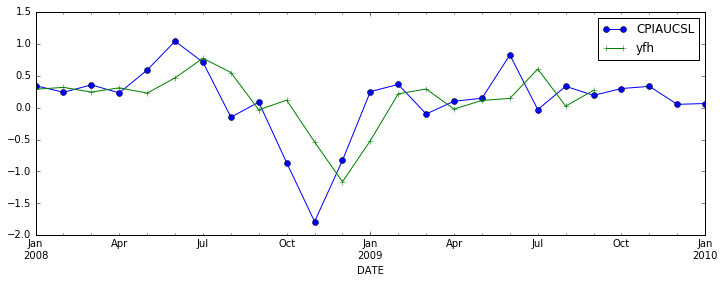

In [24]:
pd.concat([cpi_growth, fc],axis=1).loc['2008-01-01':'2010-01-01'].plot(style=['-o','-+'], figsize=(12, 4))

In [25]:

results = {h: midas_adl(cpi_growth, ffr.DFF_20090928,
                            start_date=datetime.datetime(1975,7,1),
                            end_date=datetime.datetime(1990,11,1),
                            xlag="1m",
                            ylag=1,
                            horizon=1,
                            forecast_horizon=h,
                            method='rolling') for h in (1, 2, 5)}
(results[1][0], results[2][0], results[5][0])

/Users/mikemull/Documents/Dev/midaspy/midas/weights.py:34: RuntimeWarning: overflow encountered in power
  beta_vals = u ** (self.theta1 - 1) * (1 - u) ** (self.theta2 - 1)
/Users/mikemull/Documents/Dev/midaspy/midas/weights.py:36: RuntimeWarning: invalid value encountered in true_divide
  beta_vals = beta_vals / sum(beta_vals)


(0.26393168091651681, 0.2672883585407228, 0.26560437970581507)

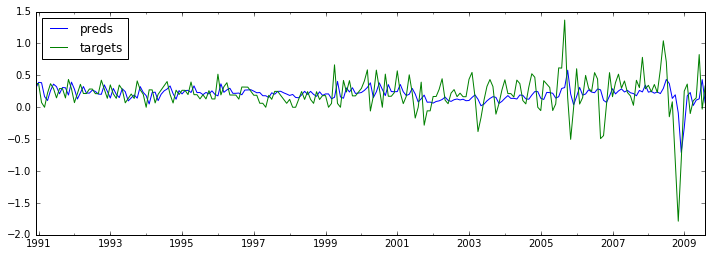

In [26]:
results[1][1].plot(figsize=(12,4))

In [27]:
results = {h: midas_adl(cpi_growth, ffr.DFF_20090928,
                            start_date=datetime.datetime(1975,10,1),
                            end_date=datetime.datetime(1991,1,1),
                            xlag="1m",
                            ylag=1,
                            horizon=1,
                            forecast_horizon=h,
                            method='recursive') for h in (1, 2, 5)}
results[1][0]

/Users/mikemull/Documents/Dev/midaspy/midas/weights.py:34: RuntimeWarning: overflow encountered in power
  beta_vals = u ** (self.theta1 - 1) * (1 - u) ** (self.theta2 - 1)
/Users/mikemull/Documents/Dev/midaspy/midas/weights.py:36: RuntimeWarning: invalid value encountered in true_divide
  beta_vals = beta_vals / sum(beta_vals)


0.26373011749736835

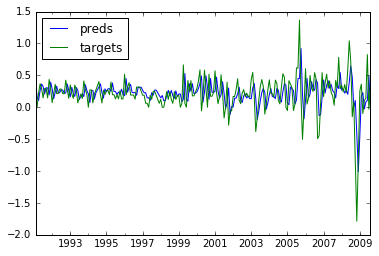

In [28]:
results[1][1].plot()